In [3]:
%load_ext autoreload
%autoreload 2

import os
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import vis
import softclustering as sc
import socceraction.spadl as spadl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
datafolder = "data"
fifa2018h5 = os.path.join(datafolder, "spadl-fifa2018.h5")
games = pd.read_hdf(fifa2018h5, key="games")
with pd.HDFStore(fifa2018h5) as store:
    actions = []  #list of DataFrames
    for game in tqdm(games.itertuples()):
        game_action = store[f"actions/game_{game.game_id}"]
        game_action = spadl.play_left_to_right(game_action, game.home_team_id)
        game_action["is_home"] = game_action["team_id"] == game.home_team_id
        actions.append(game_action)
    actions = pd.concat(actions)
    actions.drop("original_event_id", axis=1, inplace=True)
    actions = pd.merge(actions, spadl.config.actiontypes_df(), how="left")
    actions = sc.consolidate(actions)
    actions = sc.add_noise(actions)
    actions = sc.remove_outliers(actions, True)
    actions["angle"] = np.arctan2(actions.end_y - actions.start_y, actions.end_x - actions.start_x)
    actions["cos_angle"] = np.cos(actions["angle"])
    actions["sin_angle"] = np.sin(actions["angle"])

64it [00:00, 175.86it/s]


Remove 533 out of 128484 datapoints.


In [3]:
n_obs_pass = len(actions[actions["type_name"] == "pass"])
n_obs_array = [int(n_obs_pass // 10 ** i) for i in range(3, -1, -1)]
n_obs_array

[56, 562, 5624, 56248]

In [4]:
rows = []

init = "k-means++"
mask = (actions["type_name"] == "pass")
loc_data = actions.loc[mask, ["start_x", "start_y"]]
dir_data = actions.loc[mask, ["cos_angle", "sin_angle"]]
K_loc = 5
K_dir = [10 for _ in range(K_loc)]

for n_obs in n_obs_array:
    for tol in [1e-2]:
        for method in ["bregman", "approximation", "classic"]:
            loc_mixture = sc.MixtureModel(
                [sc.MultivariateGaussian() for _ in range(K_loc)],
                init=init,
                rng=10,
            )
            dir_mixtures = [sc.MixtureModel(
                [sc.VonMises() for _ in range(K_dir[j])],
                init=init,
                rng=j,
            )
                for j in range(K_loc)]

            start = time()
            model = sc.TwoLayerScheme(loc_mixture, dir_mixtures)
            model.fit(loc_data.iloc[:n_obs],
                      dir_data.iloc[:n_obs],
                      case=method,
                      tol=1e-2,
                      verbose=False)
            end = round(time() - start, 4)

            bic_score = round(model.bic_score(loc_data, dir_data), 0)

            row = {
                "n_obs": n_obs,
                "tol": tol,
                "model": method,
                "bic_score": bic_score,
                "running_time": end
            }
            print(f" {n_obs}, {tol}, {method}, {bic_score}, Time: {end}s \n")
            rows.append(row)

experiment_df = pd.DataFrame(rows)


 56, 0.01, bregman, 1759940.0, Time: 0.1142s 

 56, 0.01, approximation, 1760961.0, Time: 0.1252s 

 56, 0.01, classic, 1759947.0, Time: 0.2298s 

 562, 0.01, bregman, 1196663.0, Time: 0.1587s 

 562, 0.01, approximation, 1197057.0, Time: 0.1731s 

 562, 0.01, classic, 1196673.0, Time: 0.7299s 

 5624, 0.01, bregman, 1179601.0, Time: 1.0347s 

 5624, 0.01, approximation, 1179806.0, Time: 1.3778s 

 5624, 0.01, classic, 1179602.0, Time: 3.2241s 

 56248, 0.01, bregman, 1179653.0, Time: 38.3986s 

 56248, 0.01, approximation, 1179744.0, Time: 32.5016s 

 56248, 0.01, classic, 1179659.0, Time: 46.0395s 



In [5]:
loc_mixture

MixtureModel(n_components=5)
  ├─ (0) w=0.222  MultivariateGaussian(d=2, mean=[24.007 36.256], cov=[[129.36   21.072], [ 21.072 255.414]])
  ├─ (1) w=0.098  MultivariateGaussian(d=2, mean=[77.8   58.182], cov=[[132.072 -17.504], [-17.504  45.239]])
  ├─ (2) w=0.209  MultivariateGaussian(d=2, mean=[68.556 12.068], cov=[[217.157  11.565], [11.565 67.229]])
  ├─ (3) w=0.261  MultivariateGaussian(d=2, mean=[54.33  49.958], cov=[[204.374 -47.622], [-47.622 106.78 ]])
  └─ (4) w=0.209  MultivariateGaussian(d=2, mean=[45.632 22.918], cov=[[138.225  45.193], [ 45.193 140.866]])

In [6]:
experiment_df

,n_obs,tol,model,bic_score,running_time
0,56,0.01,bregman,1759940.0,0.1142
1,56,0.01,approximation,1760961.0,0.1252
2,56,0.01,classic,1759947.0,0.2298
3,562,0.01,bregman,1196663.0,0.1587
4,562,0.01,approximation,1197057.0,0.1731
5,562,0.01,classic,1196673.0,0.7299
6,5624,0.01,bregman,1179601.0,1.0347
7,5624,0.01,approximation,1179806.0,1.3778
8,5624,0.01,classic,1179602.0,3.2241
9,56248,0.01,bregman,1179653.0,38.3986


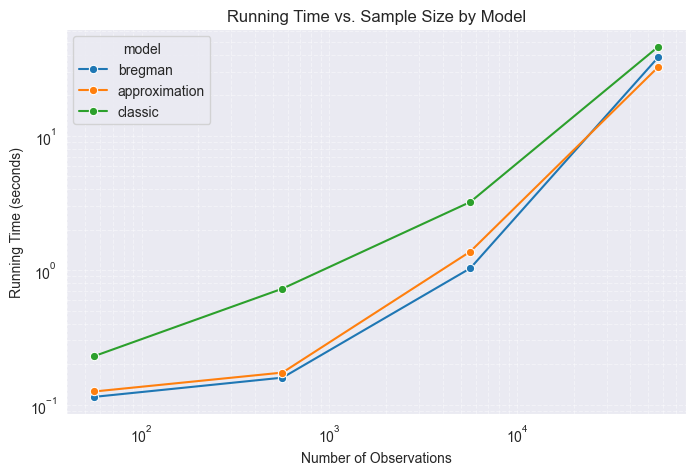

In [7]:
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=experiment_df[experiment_df["tol"] == 0.01],
    x="n_obs",
    y="running_time",
    hue="model",
    marker="o"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Observations")
plt.ylabel("Running Time (seconds)")
plt.title("Running Time vs. Sample Size by Model")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.show()

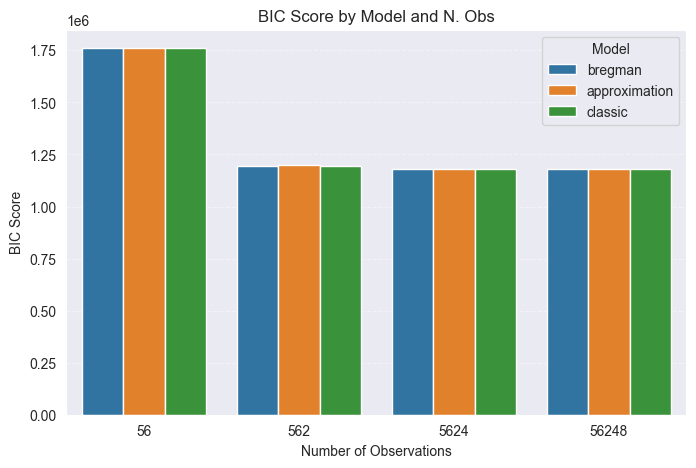

In [8]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=experiment_df,
    x="n_obs",
    y="bic_score",
    hue="model"
)

plt.xlabel("Number of Observations")
plt.ylabel("BIC Score")
plt.title("BIC Score by Model and N. Obs")
plt.legend(title="Model")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

## Synthetic data

In [52]:
def sim_data(N):
    val = []
    vm_mu = [0.0, np.pi / 3, np.pi]
    vm_kappa = [3.5, 0.8, 1.0]
    vm_syn = np.empty(shape=(N, 2))
    gauss_syn = np.empty(shape=(N, 2))
    index = 0

    for i, num in enumerate(np.random.multinomial(N, loc_mixture.weights)):
        mean, cov = loc_mixture.components[i].params
        gauss = np.random.multivariate_normal(mean, cov, size=num)
        gauss_syn[index:num + index, :] = gauss
        for j, num_vm in enumerate(np.random.multinomial(num, [0.3, 0.6, 0.1])):
            von_mises_angle = np.random.vonmises(mu=vm_mu[j] + np.random.uniform(0, 1, 1),
                                                 kappa=vm_kappa[j] + np.random.uniform(0, 0.1, 1),
                                                 size=num_vm)
            cos = np.cos(von_mises_angle)
            sin = np.sin(von_mises_angle)
            vm_syn[index:num_vm + index, :] = np.column_stack([cos, sin])
            index += num_vm

    syn_data = np.column_stack([gauss_syn, vm_syn])
    np.random.shuffle(syn_data)
    return syn_data

def experiment(n_obs_array, syn_data, methods = ("bregman", "approximation", "classic")):
    rows = []
    for n_obs in n_obs_array:
        for tol in [1e-2]:
            for method in methods:
                loc_mixture = sc.MixtureModel(
                    [sc.MultivariateGaussian() for _ in range(K_loc)],
                    init=init,
                    rng=10,
                )
                dir_mixtures = [sc.MixtureModel(
                    [sc.VonMises() for _ in range(K_dir[j])],
                    init=init,
                    rng=j,
                )
                    for j in range(K_loc)]

                start = time()
                model = sc.TwoLayerScheme(loc_mixture, dir_mixtures)
                model.fit(syn_data[:n_obs, :2],
                          syn_data[:n_obs, 2:],
                          case=method,
                          tol=1e-2,
                          verbose=False)
                end = round(time() - start, 4)

                bic_score = round(model.bic_score(loc_data, dir_data), 0)

                row = {
                    "n_obs": n_obs,
                    "tol": tol,
                    "model": method,
                    "bic_score": bic_score,
                    "running_time": end
                }
                #print(f" {n_obs}, {tol}, {method}, {bic_score}, {end}")
                rows.append(row)

    return rows

def logger(N0, N1, methods = ("bregman", "approximation", "classic")):
    syn_data = sim_data(N1)
    n_obs_array = np.linspace(start=N0,
                              stop = N1 - N0,
                              num = int((N1-N0)/N0),
                              dtype=int)
    return experiment(n_obs_array, syn_data, methods)


In [53]:
init = "k-means++"
K_loc = 5
K_dir = [3 for _ in range(K_loc)]

N0 = 10
N1 = 100
N2 = 1_000
N3 = 10_000
N4 = 100_000
N5 = 1_000_000

rows_1 = logger(N0, N1)
print("Ready: ",N1)
rows_2 = logger(N1, N2)
print("Ready: ",N2)
rows_3 = logger(N2, N3)
print("Ready: ",N3)
rows_4 = logger(N3, N4)
print("Ready: ",N4)


Ready:  100
Ready:  1000
Ready:  10000
Ready:  100000


In [54]:
rows_5 = logger(N4, N5, methods=["bregman","approximation"])
print("Ready: ",N5)

Ready:  1000000


,n_obs,tol,model,bic_score,running_time
0,10,0.01,bregman,5695900.0,0.0498
1,10,0.01,approximation,5708919.0,0.0436
2,10,0.01,classic,5695902.0,0.0878
3,20,0.01,bregman,1958464.0,0.0398
4,20,0.01,approximation,1966336.0,0.0333
...,...,...,...,...,...
121,700000,0.01,approximation,1211533.0,282.1071
122,800000,0.01,bregman,1212296.0,185.5256
123,800000,0.01,approximation,1211744.0,444.4027
124,900000,0.01,bregman,1212763.0,118.0705


In [55]:
experiment_syn_df = pd.DataFrame(rows_1 + rows_2 + rows_3 + rows_4 + rows_5)

In [56]:
experiment_syn_df

,n_obs,tol,model,bic_score,running_time
0,10,0.01,bregman,5695900.0,0.0498
1,10,0.01,approximation,5708919.0,0.0436
2,10,0.01,classic,5695902.0,0.0878
3,20,0.01,bregman,1958464.0,0.0398
4,20,0.01,approximation,1966336.0,0.0333
...,...,...,...,...,...
121,700000,0.01,approximation,1211533.0,282.1071
122,800000,0.01,bregman,1212296.0,185.5256
123,800000,0.01,approximation,1211744.0,444.4027
124,900000,0.01,bregman,1212763.0,118.0705


In [4]:
experiment_syn_df = pd.DataFrame([
[10,0.01,'bregman',5695900,0.0498],
[10,0.01,'approximation',5708919,0.0436],
[10,0.01,'classic',5695902,0.0878],
[20,0.01,'bregman',1958464,0.0398],
[20,0.01,'approximation',1966336,0.0333],
[20,0.01,'classic',1959007,0.0847],
[30,0.01,'bregman',2038446,0.0611],
[30,0.01,'approximation',2046607,0.0635],
[30,0.01,'classic',2038541,0.0925],
[40,0.01,'bregman',1479309,0.0409],
[40,0.01,'approximation',1488666,0.0392],
[40,0.01,'classic',1477694,0.1749],
[50,0.01,'bregman',1331668,0.033],
[50,0.01,'approximation',1346001,0.039],
[50,0.01,'classic',1308244,0.156],
[60,0.01,'bregman',1307976,0.0436],
[60,0.01,'approximation',1315374,0.0429],
[60,0.01,'classic',1296060,0.1551],
[70,0.01,'bregman',1333744,0.0586],
[70,0.01,'approximation',1339081,0.042],
[70,0.01,'classic',1329380,0.2491],
[80,0.01,'bregman',1296215,0.0459],
[80,0.01,'approximation',1300605,0.0469],
[80,0.01,'classic',1296186,0.2257],
[90,0.01,'bregman',1257701,0.0486],
[90,0.01,'approximation',1261076,0.0434],
[90,0.01,'classic',1258041,0.1782],

[100,0.01,'bregman',1266359,0.0376],
[100,0.01,'approximation',1272093,0.0413],
[100,0.01,'classic',1264837,0.2383],
[200,0.01,'bregman',1235335,0.0659],
[200,0.01,'approximation',1238192,0.0544],
[200,0.01,'classic',1234740,0.4028],
[300,0.01,'bregman',1213398,0.0546],
[300,0.01,'approximation',1215274,0.0528],
[300,0.01,'classic',1212900,0.2056],
[400,0.01,'bregman',1214466,0.0772],
[400,0.01,'approximation',1216132,0.0661],
[400,0.01,'classic',1215025,0.2745],
[500,0.01,'bregman',1210376,0.0871],
[500,0.01,'approximation',1212240,0.0555],
[500,0.01,'classic',1210739,0.1955],
[600,0.01,'bregman',1211893,0.0798],
[600,0.01,'approximation',1213801,0.095],
[600,0.01,'classic',1211446,0.3835],
[700,0.01,'bregman',1210786,0.0939],
[700,0.01,'approximation',1212389,0.1108],
[700,0.01,'classic',1211442,0.3196],
[800,0.01,'bregman',1211267,0.0842],
[800,0.01,'approximation',1212360,0.1282],
[800,0.01,'classic',1211372,0.3151],
[900,0.01,'bregman',1209886,0.095],
[900,0.01,'approximation',1211219,0.1689],
[900,0.01,'classic',1209996,0.3066],

[1000,0.01,'bregman',1207635,0.1623],
[1000,0.01,'approximation',1208486,0.1779],
[1000,0.01,'classic',1207637,0.4606],
[2000,0.01,'bregman',1205545,0.1939],
[2000,0.01,'approximation',1206332,0.2318],
[2000,0.01,'classic',1205599,0.5547],
[3000,0.01,'bregman',1209657,0.3367],
[3000,0.01,'approximation',1209726,0.4621],
[3000,0.01,'classic',1209324,1.0496],
[4000,0.01,'bregman',1208001,0.3407],
[4000,0.01,'approximation',1208745,0.508],
[4000,0.01,'classic',1208189,1.0804],
[5000,0.01,'bregman',1208567,0.8581],
[5000,0.01,'approximation',1209930,0.6268],
[5000,0.01,'classic',1208812,2.0078],
[6000,0.01,'bregman',1208287,0.4122],
[6000,0.01,'approximation',1209759,0.5438],
[6000,0.01,'classic',1208213,0.9549],
[7000,0.01,'bregman',1208307,0.7379],
[7000,0.01,'approximation',1209257,1.1448],
[7000,0.01,'classic',1208309,2.4831],
[8000,0.01,'bregman',1208018,0.9448],
[8000,0.01,'approximation',1208518,1.3477],
[8000,0.01,'classic',1208184,3.0564],
[9000,0.01,'bregman',1208834,0.8952],
[9000,0.01,'approximation',1209422,1.096],
[9000,0.01,'classic',1208992,4.2046],

[10000,0.01,'bregman',1203573,2.1886],
[10000,0.01,'approximation',1204724,1.1469],
[10000,0.01,'classic',1203657,5.4932],
[20000,0.01,'bregman',1203814,2.3824],
[20000,0.01,'approximation',1205560,1.6434],
[20000,0.01,'classic',1203962,6.4828],
[30000,0.01,'bregman',1203272,4.5507],
[30000,0.01,'approximation',1204530,3.7891],
[30000,0.01,'classic',1203354,15.7154],
[40000,0.01,'bregman',1202763,4.9348],
[40000,0.01,'approximation',1203202,10.0103],
[40000,0.01,'classic',1202756,24.6309],
[50000,0.01,'bregman',1203384,5.3558],
[50000,0.01,'approximation',1203470,14.4548],
[50000,0.01,'classic',1203421,33.3902],
[60000,0.01,'bregman',1203218,14.3962],
[60000,0.01,'approximation',1203528,11.4878],
[60000,0.01,'classic',1203188,41.4523],
[70000,0.01,'bregman',1203193,14.4923],
[70000,0.01,'approximation',1204555,14.3357],
[70000,0.01,'classic',1203321,52.4047],
[80000,0.01,'bregman',1202901,15.6234],
[80000,0.01,'approximation',1202956,17.9101],
[80000,0.01,'classic',1203039,50.7976],
[90000,0.01,'bregman',1203966,22.4991],
[90000,0.01,'approximation',1204092,23.3311],
[90000,0.01,'classic',1203899,69.2894],

[100000,0.01,'bregman',1211446,12.0846],
[100000,0.01,'approximation',1212454,16.535],
[200000,0.01,'bregman',1211796,68.4655],
[200000,0.01,'approximation',1212168,56.6953],
[300000,0.01,'bregman',1212862,186.7009],
[300000,0.01,'approximation',1213000,98.0085],
[400000,0.01,'bregman',1211979,72.9596],
[400000,0.01,'approximation',1212044,173.0419],
[500000,0.01,'bregman',1212756,120.2853],
[500000,0.01,'approximation',1212580,217.7321],
[600000,0.01,'bregman',1212266,179.4779],
[600000,0.01,'approximation',1211736,281.6361],
[700000,0.01,'bregman',1211642,342.596],
[700000,0.01,'approximation',1211533,282.1071],
[800000,0.01,'bregman',1212296,185.5256],
[800000,0.01,'approximation',1211744,444.4027],
[900000,0.01,'bregman',1212763,118.0705],
[900000,0.01,'approximation',1211951,750.3142],

[1000000,0.01,'bregman',1203146,388.0165],
[1000000,0.01,'approximation',1202605,525.79],

], columns=["n_obs", "tol", "model", "bic_score", "running_time"])


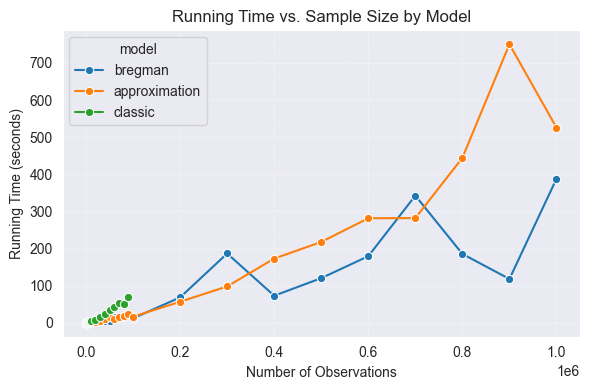

In [6]:
plt.figure(figsize=(6, 4))
sns.lineplot(
    data=experiment_syn_df[experiment_syn_df["tol"] == 0.01],
    x="n_obs",
    y="running_time",
    hue="model",
    marker="o"
)

#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Number of Observations")
plt.ylabel("Running Time (seconds)")
plt.title("Running Time vs. Sample Size by Model")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(f'plots/time_complexity.pdf')
plt.show()

(10000, 4)